# Предсказываем спрос на аренду велосипедов

https://www.kaggle.com/c/bike-sharing-demand

Системы совместного использования велосипедов - это средство аренды велосипедов, где процесс получения членства, аренды и возврата велосипедов автоматизирован через сеть киосков по всему городу. Используя эти системы, люди могут арендовать велосипед из одного места и возвращать его в другое место по мере необходимости. В настоящее время в мире действует более 500 программ обмена велосипедами.

Данные, сгенерированные этими системами, делают их привлекательными для исследователей, поскольку продолжительность поездки, место отправления, место прибытия и истекшее время явно записаны. Поэтому системы совместного использования велосипедов функционируют как сенсорная сеть, которую можно использовать для изучения мобильности в городе. В этом конкурсе участников просят объединить исторические модели использования с данными о погоде, чтобы прогнозировать спрос на аренду велосипедов в рамках программы Capital Bikeshare в Вашингтоне, округ Колумбия.

Тренировочный набор состоит из первых 19 дней каждого месяца, а тестовый набор - с 20-го по конец месяца.


# Задача 

Спрогнозировать общее количество велосипедов, арендованных в течение каждого часа, покрываемого тестовым набором, используя только информацию, доступную до периода проката.

# Описание датасета:

Параметры:

datetime - почасовая дата + отметка времени

season - 1 = весна, 2 = лето, 3 = осень, 4 = зима

holiday - считается ли день праздником

workingday - будь то выходной или праздничный день

weather - 1: Ясно, Облачно, Небольшая Облачность

2: Туман + Облачно, Туман + Разбитые облака, Туман + Немного облаков, Туман

3: легкий снег, легкий дождь + гроза + рассеянные облака, легкий дождь + рассеянные облака

4: сильный дождь + ледяные поддоны + гроза + туман, снег + туман

temp - температура в градусах Цельсия

atemp - "ощущается как" температура в градусах Цельсия

humidity - относительная влажность

windspeed - скорость ветра

casual - количество инициированных прокатов незарегистрированных пользователей

registered - количество зарегистрированных арендованных пользователей

count - количество всех арендных плат

# Туториал

#### 1) Скачаем необходимые для работы библиотеки

        a) numpy - расширение языка Python, добавляющее поддержку больших многомерных массивов и матриц, вместе с большой библиотекой высокоуровневых математических функций для операций с этими массивами
        б) pandas - различные структуры данных и анализ
        в) pydot
        г) sklearn - С помощью нее можно реализовать различные алгоритмы классификации, регрессии и кластеризации, в том числе алгоритмы SVM, случайного леса, k-ближайших соседей и DBSCAN, которые построены на взаимодействии библиотек NumPy и SciPy с Python.
        д) matplotlib - библиотека на языке программирования Python для визуализации данных двумерной (2D) графикой (3D графика также поддерживается)
        е) seaborn - это библиотека визуализации данных Python, основанная на matplotlib.

In [1]:
import numpy as np
import pandas as pd
import pydot as p
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics, pipeline, preprocessing
from sklearn.ensemble import RandomForestRegressor
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

#### 2) Скачаем необходимые данные и исследуем их начальное состояние

In [3]:
#импорт датасета
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
submission = pd.read_csv('sampleSubmission.csv')

In [4]:
#вывод первых пяти строк трейновой выборки
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
#вывод первых пяти строк тестовой выборки
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
# Выводим статистику для train по значениям признаков: 
# среднее, стандартное отклонение, минимальное и максимальное значения, квартили
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [7]:
# Выводим статистику для test по значениям признаков: 
# среднее, стандартное отклонение, минимальное и максимальное значения, квартили
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [8]:
# узнаем по каждому параметру кол-во переменных, их формат и есть ли пустые значения.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [9]:
# узнаем по каждому параметру кол-во переменных, их формат и есть ли пустые значения.
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [10]:
# узнаем кол-во иследуемых объектов и кол-во оцениваемых признаков
train.shape

(10886, 12)

In [11]:
# узнаем кол-во иследуемых объектов и кол-во оцениваемых признаков
test.shape

(6493, 9)

In [12]:
# Проверка на пропущенные данные
train.isnull().any().any()

False

In [13]:
# Проверка на пропущенные данные
test.isnull().any().any()

False

#### Выводы: 
          1) Нет пропущенных значений по всем признакам
          2) В train есть 3 target переменных (casual, registered, count) 
          3) После обучения моделей на train.csv сделаем прогноз для тестовой выборки test.csv

#### 3) Чтобы лучше разобраться в данных, визуализируем их с помощью библиотеки matplotlib, отдельно выделим таргет переменную count

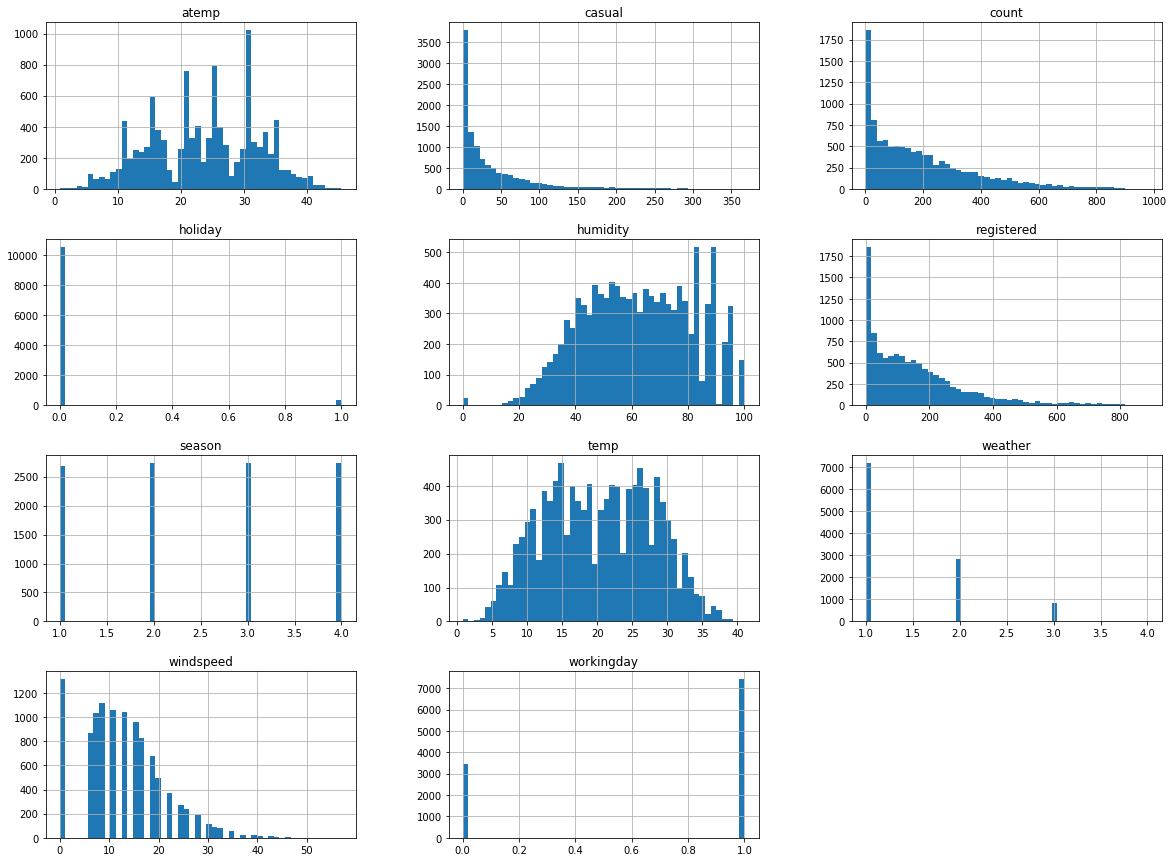

In [14]:
# визуализация данных
train.hist(bins=50, figsize=(20,15))
plt.show()

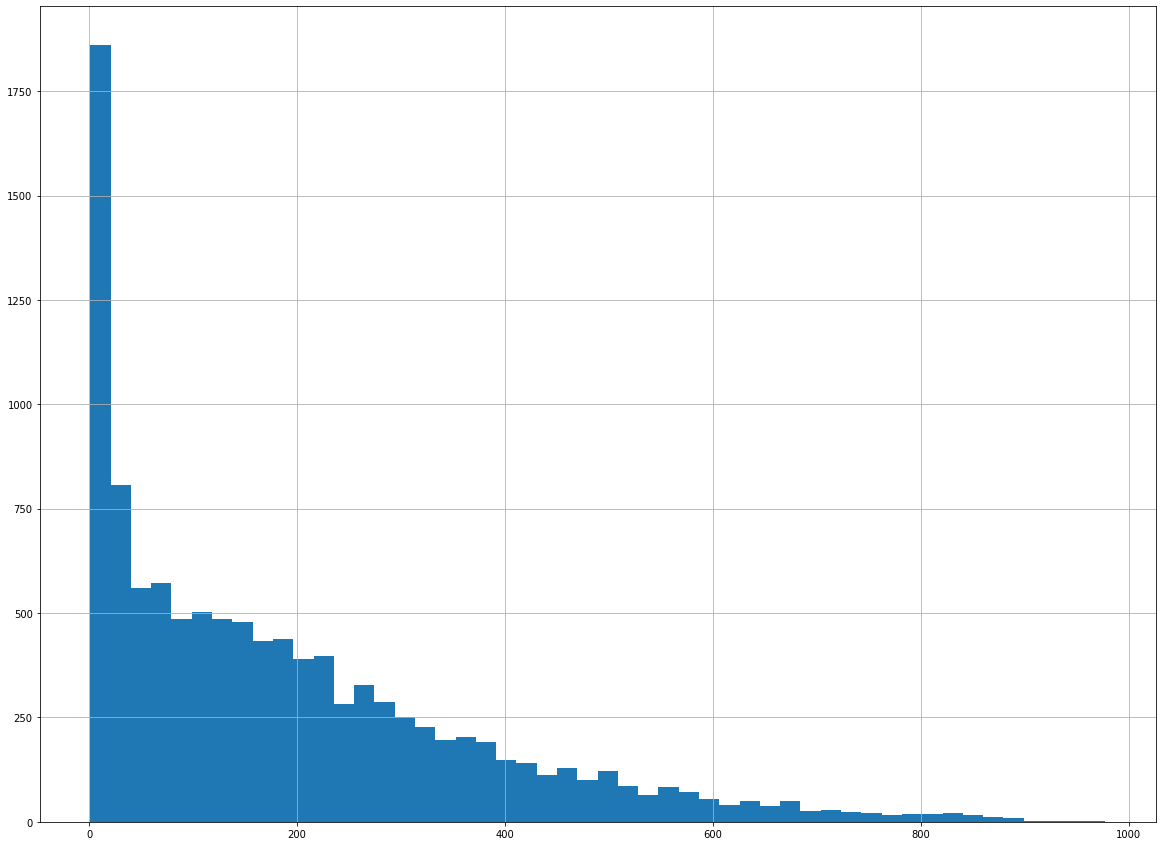

In [15]:
train['count'].hist(bins=50, figsize=(20,15))

#### 4) Рассмотрим корреляцию между нашими параметрами

В математической статистике корреляция — понятие, которым отмечают связь между явлениями, если одно из них входит в число причин, определяющих другие, или если имеются общие причины, воздействующие на эти явления (функция является частным случаем корреляции); корреляция может быть более или менее тесной (т. е. зависимость одной величины от другой — более или менее ясно выраженной); число, показывающее степень тесноты корреляции, называется коэффициентом корреляции (это число заключено между -1 и 1);

1 - положительная корреляция -1 - отрицательная корреляция 0 - не коррелируют

В pandas есть 3 метода для функции corr



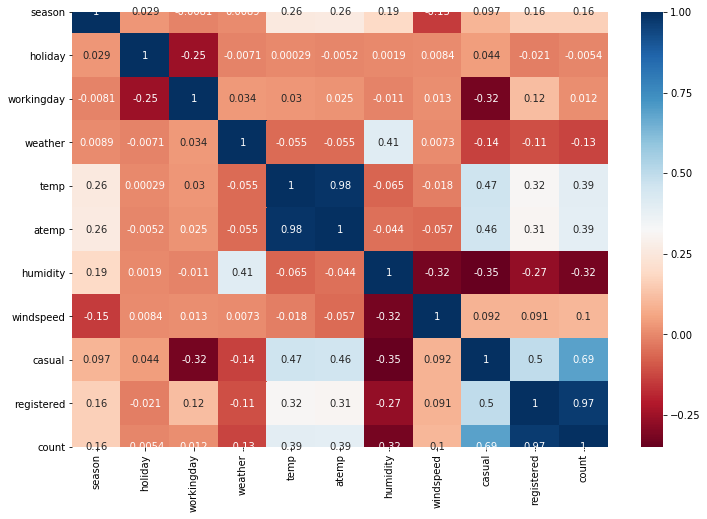

In [16]:
#pearson : standard correlation coefficient - стандартный коэффициент корреляции 
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="pearson"), annot =True, cmap='RdBu')
plt.show()

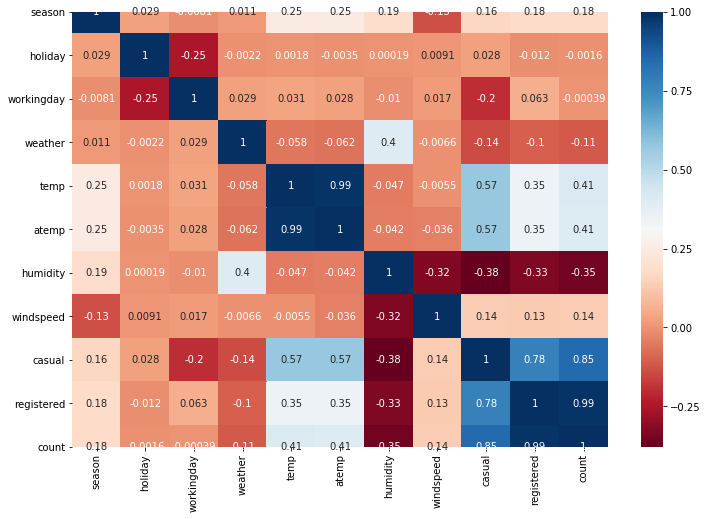

In [17]:
# spearman : Spearman rank correlation - Коэффициент ранговой корреляции Спирмена
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="spearman"), annot =True, cmap='RdBu')
plt.show()

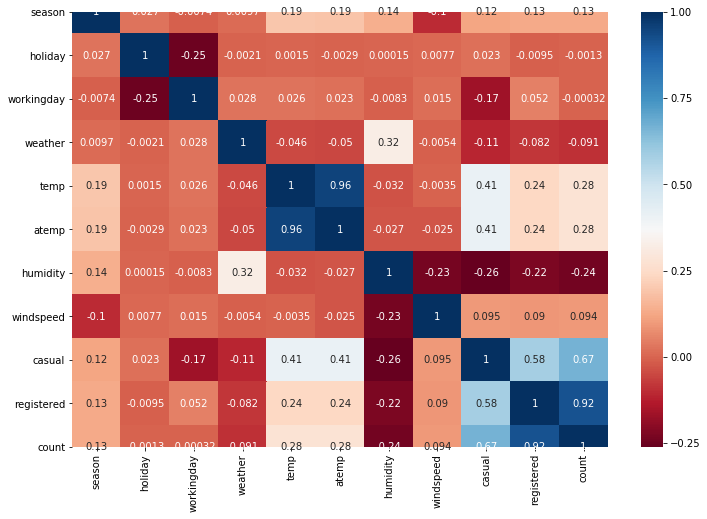

In [18]:
# kendall : Kendall Tau correlation coefficient - Коэффициент ранговой корреляции Кендалла
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="kendall"), annot =True, cmap='RdBu')
plt.show()

#### 4) Перейдем к обработке наших данных. 
У нас есть параметр datetime, разделим его на число, месяц, час, день недели.
Теперь давайте рассмотрим как влияет день недели на кол-во арендаторов.


In [19]:
# делим datetime на параметры
train.datetime = train.datetime.apply(pd.to_datetime)
train['month'] = train.datetime.apply(lambda x : x.month)
train['hour'] = train.datetime.apply(lambda x : x.hour)
train['date'] = train.datetime.apply(lambda x : x.day)
train['weekday'] = train.datetime.apply(lambda x : x.weekday())
train.head(400)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,date,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,1,0,1,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,1,2,1,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,1,3,1,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,1,4,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2011-01-17 23:00:00,1,1,0,3,6.56,6.820,86,19.0012,1,3,4,1,23,17,0
396,2011-01-18 12:00:00,1,0,1,2,8.20,9.090,86,22.0028,0,3,3,1,12,18,1
397,2011-01-18 13:00:00,1,0,1,2,8.20,9.850,86,15.0013,0,22,22,1,13,18,1
398,2011-01-18 14:00:00,1,0,1,2,9.02,11.365,80,11.0014,2,26,28,1,14,18,1


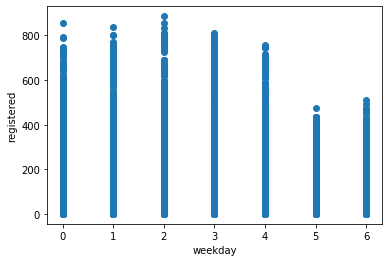

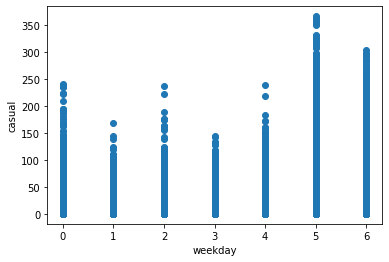

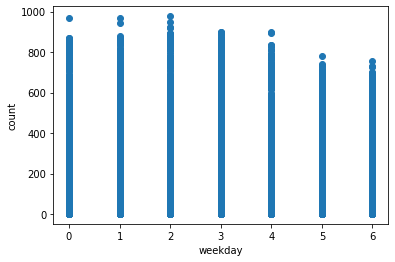

In [20]:
# статистика по дням недели для зарегестрированных пользователей
plt.scatter(train['weekday'], train['registered'])
plt.xlabel('weekday')
plt.ylabel('registered')
plt.show()
# статистика по дням недели для не зарегестрированных пользователей
plt.scatter(train['weekday'], train['casual'])
plt.xlabel('weekday')
plt.ylabel('casual')
plt.show()
# статистика по дням недели для не зарегестрированных пользователей
plt.scatter(train['weekday'], train['count'])
plt.xlabel('weekday')
plt.ylabel('count')
plt.show()

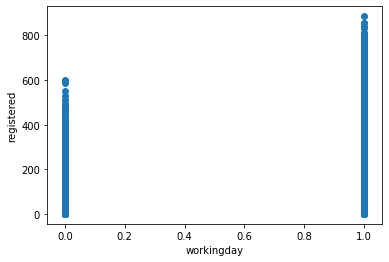

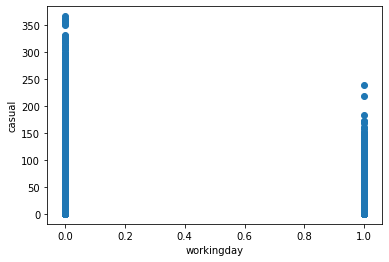

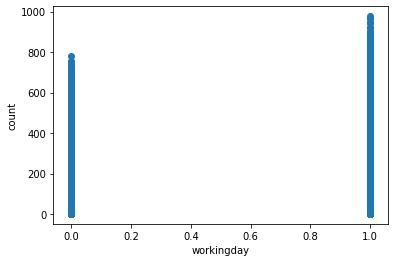

In [21]:
# статистика по рабочим/выходным дням недели для зарегестрированных пользователей
plt.scatter(train['workingday'], train['registered'])
plt.xlabel('workingday')
plt.ylabel('registered')
plt.show()
# статистика по рабочим/выходным дням недели для не зарегестрированных пользователей
plt.scatter(train['workingday'], train['casual'])
plt.xlabel('workingday')
plt.ylabel('casual')
plt.show()
# статистика по рабочим/выходным дням недели для всех пользователей
plt.scatter(train['workingday'], train['count'])
plt.xlabel('workingday')
plt.ylabel('count')
plt.show()

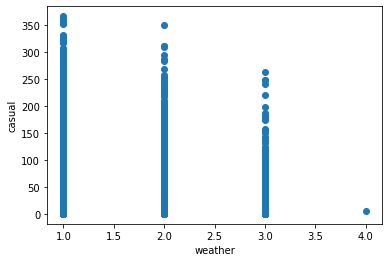

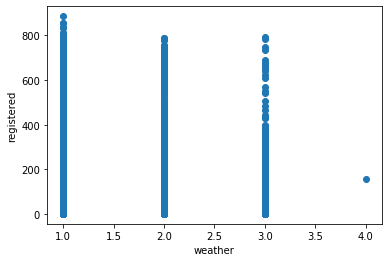

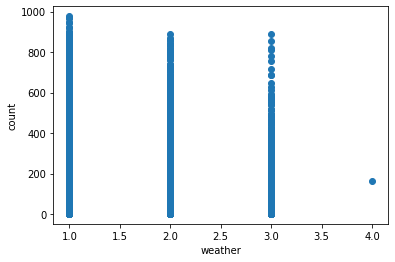

In [22]:
# статистика по погоде для незарегистрированных пользователей
plt.scatter(train['weather'], train['casual'])
plt.xlabel('weather')
plt.ylabel('casual')
plt.show()

# статистика по погоде для зарегистрированных пользователей
plt.scatter(train['weather'], train['registered'])
plt.xlabel('weather')
plt.ylabel('registered')
plt.show()

# статистика по погоде для всех пользователей
plt.scatter(train['weather'], train['count'])
plt.xlabel('weather')
plt.ylabel('count')
plt.show()

Отметим что данные являются ли пользователи зарегистрированными или нет не влияют на таргет переменную, поэтому удалим столбцы registered и casual, также признаки workingday и weekday имеют схожий смысл, поэтому можем удалить один из них.

In [23]:
train = train.drop(['datetime'], axis = 1);

In [24]:
 train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,date,weekday
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,1,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2,1,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3,1,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4,1,5


 В таблице X оставим необходимые для изучения данных параметры, в таблице Y - один столбик содержащий таргет переменную

In [25]:
# X = train.drop(['datetime','weekday','count', 'casual', 'registered'], axis = 1)
X = train.drop(['count', 'casual', 'registered'], axis = 1)
Y = train['count'].values

In [26]:
train_data, test_data, train_labels, test_labels = train_test_split(X, Y)

#### 5) Перейдем к построению моделей

Импортируем необходимые библиотеки

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

Выпишем модели регрессси, которые хотим использовать, в словарь

In [56]:
model = RandomForestRegressor()
parameters = {'criterion' : ['mse', 'mae'],
                  'min_samples_split' : range(2,5),
                  'max_depth' : range(1,10)
                }
grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1)
grid.fit(train_data, train_labels)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],

In [57]:
model = DecisionTreeRegressor()
parameters = {'criterion' : ['mse', 'friedman_mse', 'mae'],
                  'min_samples_split' : range(2,5),
                  'max_depth' : range(1,10)
                }
grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1)
grid.fit(train_data, train_labels)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': range(1, 10),
                         'min_samples_split': range(2, 5)},
             pre_dispatch='

In [58]:
regressions = {}
regressions["LinearRegression"] = LinearRegression()
regressions["Ridge"]  = Ridge()
regressions["RidgeCV"]   = RidgeCV()
regressions["ElasticNet"]  = ElasticNet()
regressions["Lasso"]  = Lasso()
regressions["AdaBoostRegressor"] = AdaBoostRegressor()
regressions["BaggingRegressor"] = BaggingRegressor()
regressions["ExtraTreesRegressor"] = ExtraTreesRegressor()
regressions["GradientBoostingRegressor"]  = GradientBoostingRegressor()
regressions["RandomForestRegressor"]    = RandomForestRegressor()
regressions["DecisionTreeRegressor"]    = DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best')

Для каждой модели, используя кросс-валидацию, выведем среднее значение и стандартное отклонение

In [59]:
regResult = []
models = []
for name in regressions:
    model = regressions[name]
    res = cross_val_score(model, train_data, train_labels)
    regResult.append(res)
    models.append(name)
    print("{}: {}, {}".format(name, round(res.mean(), 3), round(res.std(), 3)))

LinearRegression: 0.336, 0.008
Ridge: 0.336, 0.008
RidgeCV: 0.336, 0.008
ElasticNet: 0.336, 0.007
Lasso: 0.336, 0.008
AdaBoostRegressor: 0.593, 0.014
BaggingRegressor: 0.849, 0.007
ExtraTreesRegressor: 0.846, 0.005
GradientBoostingRegressor: 0.785, 0.012
RandomForestRegressor: 0.844, 0.005
DecisionTreeRegressor: 0.717, 0.017


## Линейные модели

Ниже приведен набор методов, предназначенных для регрессии, в которых целевое значение, как ожидается, представляет собой линейную комбинацию признаков.  $\hat{y}$ - прогнозируемое значение

$$\hat{y}(w, x) = w_0 + w_1 x_1 + ... + w_p x_p$$

Через модуль мы обозначаем вектор  $w = (w_1,
..., w_p)$ как coef_ и $w_0$
 как intercept_.

 Линейная регрессия очень хороша, чтобы ответить на следующие вопросы:

    Есть ли связь между 2 переменными?

    Какая переменная вносит наибольший вклад?

    Насколько точно мы можем оценить влияние каждой переменной?

    Насколько точно мы можем предсказать цель?


Чтобы найти коэффициенты, нам нужно минимизировать сумму квадратов ошибок. Конечно, линейная модель не идеальна, и она не будет точно предсказывать все данные, а это означает, что существует разница между фактическим значением и прогнозом. Ошибка легко вычисляется с помощью:

$$ X w - y$$

Почему ошибки возводятся в квадрат?

Мы возводим в квадрат ошибку, потому что прогноз может быть выше или ниже истинного значения, что приводит к отрицательной или положительной разнице соответственно. Если бы мы не возводили в квадрат ошибки, сумма ошибок могла бы уменьшиться из-за отрицательных различий, а не потому, что модель хорошо подходит. Кроме того, возведение в квадрат ошибок учитывает большие различия, поэтому минимизация квадратов ошибок «гарантирует» лучшую модель.

## LinearRegression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

LinearRegression соответствует линейной модели с коэффициентами $w = (w_1, ..., w_p)$, чтобы минимизировать остаточную сумму квадратов между наблюдаемыми целями в наборе данных и целями, прогнозируемыми линейным приближением. Математически это решает проблему вида: 

$$\min_{w} || X w - y||_2^2$$

Гребневая и Лассо опираются на линейную модель, но их фундаментальной особенностью является регуляризация. Цель - улучшить функцию потерь, чтобы она зависела не только от суммы квадратов разностей, но и от коэффициентов регрессии.

#### Регуляризация


Регуляризация — метод добавления некоторых дополнительных ограничений к условию с целью решить некорректно поставленную задачу или предотвратить переобучение. Чаще всего эта информация имеет вид штрафа за сложность модели.

Переобучение в большинстве случаев проявляется в том, что итоговые модели имеют слишком большие значения параметров. Соответственно, необходимо добавить в целевую функцию штраф за это. Наиболее часто используемые виды регуляризации — L1 и L2


L2-регуляризация

$Q(β,X^l)=\sum_{i=1}^{l}L(y_i,g(x_i,β))+λ\sum_{j=1}^{n}β_j^2$ 

Минимизация регуляризованного cоответствующим образом эмпирического риска приводит к выбору такого вектора параметров β, которое не слишком сильно отклоняется от нуля. В линейных классификаторах это позволяет избежать проблем мультиколлинеарности и переобучения.

L1-регуляризация

$Q(β,X^l)=\sum_{i=1}^{l}L(y_i,g(x_i,β))+λ\sum_{j=1}^{n}|β_j|$

Данный вид регуляризации также позволяет ограничить значения вектора β. Однако, к тому же он обладает интересным и полезным на практике свойством — обнуляет значения некоторых параметров, что в случае с линейными моделями приводит к отбору признаков.

В представленных формулах для эмпирического риска Q: L является функцией потерь, а β — вектором параметров g(x,β) из модели алгоритма, а λ — неотрицательный гиперпараметр, являющийся коэффициентом регуляризации.

## Ridge

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge


Усовершенствование линейной регрессии с повышенной устойчивостью к ошибкам, налагающая ограничения на коэффициенты регрессии для получения куда более приближенного к реальности результата. Вдобавок, этот результат гораздо проще интерпретировать. Применяется метод для борьбы с переизбыточностью данных, когда независимые переменные коррелируют друг с другом (мультиколлинеарность).

Ридж-регрессия или гребневая регрессия предполагает оценку параметров по следующей формуле:

![title](14.png)

## RidgeCV
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV

Гребневая регрессия со встроенной перекрестной проверкой.

## Lasso

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso



Сходна с гребневой, за исключением того, что коэффициенты регрессии могут равняться нулю (часть признаков при этом исключается из модели).

![title](15.png)

## ElasticNet

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

Эластичная сеть — модель регрессии с двумя регуляризаторами l1, l2

## Lars

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html#sklearn.linear_model.Lars

LARS решает следующую задачу. Пусть назначена линейная регрессионная модель. При большом количестве свободных переменных возникает проблема неустойчивого оценивания весов модели. LARS предлагает метод выбора такого набора свободных переменных, который имел бы наиболее значимую статистическую связь с зависимой переменной. Также LARS предлагает метод оценки весов.

Алгоритм LARS похож на алгоритм шаговой регрессии. Различие в том, что алгоритм LARS, вместо последовательного добавления свободных переменных, на каждом шаге изменяет их веса. Веса увеличиваются так, чтобы доставить наибольшую корреляцию с вектором регрессионных остатков. Основным достоинством LARS является то, что он выполняется за число шагов, не превышающее число свободных переменных. Частным случаем алгоритма LARS является алгоритм LASSO.

## AdaBoostRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor

Регрессор AdaBoost - это метаоценщик, который начинается с подгонки регрессора к исходному набору данных, а затем подгоняет дополнительные копии регрессора к тому же набору данных, но где веса экземпляров корректируются в соответствии с ошибкой текущего прогноза. Таким образом, последующие регрессоры больше внимания уделяют трудным случаям.

## BaggingRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor

Метаоценщик ансамбля, который подбирает базовые регрессоры каждый на случайных подмножествах исходного набора данных и затем объединяет их отдельные прогнозы (путем голосования или усреднения) для формирования окончательного прогноза. Такой метаоценщик обычно можно использовать как способ уменьшить дисперсию оценщика черного ящика (например, дерева решений) путем введения рандомизации в процедуру его построения и последующего создания из нее ансамбля.

## ExtraTreesRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor

В этом классе реализована метаоценка, которая соответствует ряду рандомизированных деревьев решений (например, лишних деревьев) в различных подвыборках набора данных и использует усреднение для повышения точности прогнозирования и контроля соответствия.

## GradientBoostingRegressor
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

GB строит аддитивную модель поэтапно; это позволяет оптимизировать произвольные дифференцируемые функции потерь. На каждом этапе дерево регрессии соответствует отрицательному градиенту заданной функции потерь.

## RandomForestRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

Случайный лес - это метаоценщик, который подходит к ряду классификационных деревьев решений по различным подвыборкам набора данных и использует усреднение для повышения точности прогнозирования и контроля соответствия. Размер подвыборки контролируется параметром max_samples, если bootstrap = True (по умолчанию), в противном случае весь набор данных используется для построения каждого дерева.

## DecisionTreeRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor


Дерево решений — логический алгоритм классификации, решающий задачи классификации и регрессии. Представляет собой объединение логических условий в структуру дерева.

In [60]:
# выделяем бинарные данные
binary_columns = ['holiday', 'workingday']
binary_indices = np.array([(column in binary_columns) for column in X.columns], dtype = bool)
# выделяем категориальные данные
categorical_columns = ['season', 'weather', 'month', 'date', 'weekday']
categorical_indieces = np.array([(column in  categorical_columns) for column in X.columns], dtype = bool)
# выделяем интервальные данные
numeric_columns = ['temp', 'atepm', 'humidity', 'windspeed', 'hour']
numeric_indices = np.array([(column in numeric_columns) for column in X.columns], dtype = bool)

estimators = {}
for name in regressions:
    model = regressions[name]
    estimator = pipeline.Pipeline(steps = [
    ('feature_processing0', pipeline.FeatureUnion(transformer_list = [
        ('binary_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_indices], validate = True)),
        
        ('numeric_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_indices])),
            ('scaling', preprocessing.StandardScaler(with_mean = 0.))
                ])),
        
        ('categorical_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_indieces])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
                ])),
    ])),
    ('model_fitting', model)
    ])
    estimators[name] = estimator;

In [48]:
print(estimators)

{'LinearRegression': Pipeline(memory=None,
         steps=[('feature_processing0',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x0000020A6CE2EAF8>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=True)),
                                                ('numeric_processing',
   

Для каждой модели выводим оценку и среднюю ошибку

In [61]:
for name in estimators:
    estimators[name].fit(np.array(train_data), train_labels)
    print("{}: {}, {}".format(name, estimators[name].score(train_data, train_labels), metrics.mean_absolute_error(test_labels, estimators[name].predict(np.array(test_data)))))

LinearRegression: 0.3578017956147239, 106.39539544457195
Ridge: 0.3577955812260001, 106.3965047070445
RidgeCV: 0.3577443340725507, 106.38651928550522
ElasticNet: 0.3077216626681478, 111.74811522898686
Lasso: 0.3523870072352435, 106.28787161379574
AdaBoostRegressor: 0.5648019715983548, 97.5645875965033
BaggingRegressor: 0.9743998462405093, 45.642432035268186
ExtraTreesRegressor: 0.9999999534405155, 42.37277736958119
GradientBoostingRegressor: 0.8035468465803739, 57.69695723640429
RandomForestRegressor: 0.9747018372400456, 45.126377663482735
DecisionTreeRegressor: 1.0, 55.613519470977224


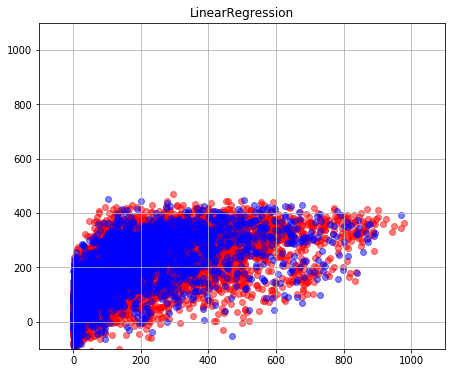

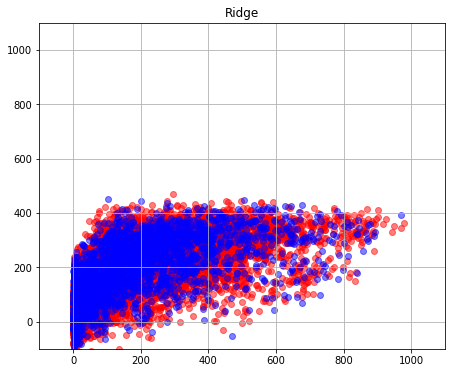

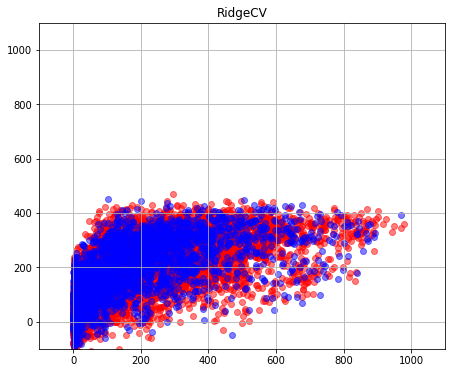

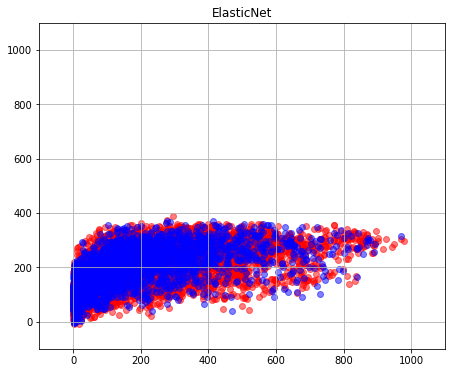

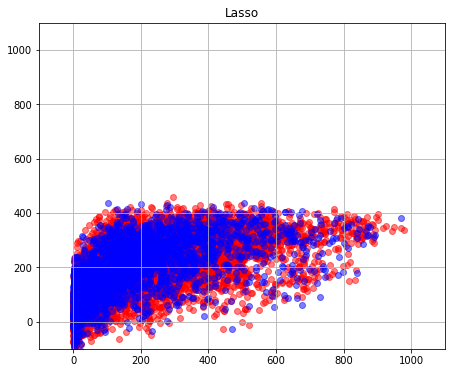

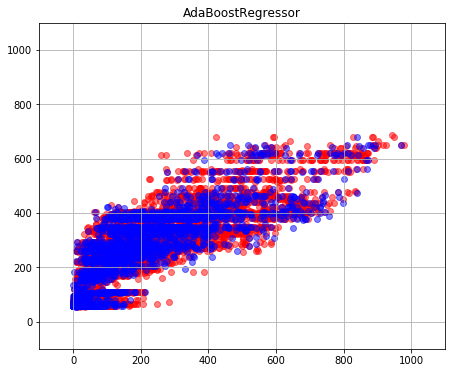

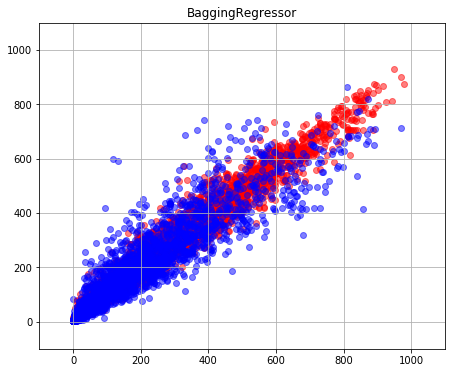

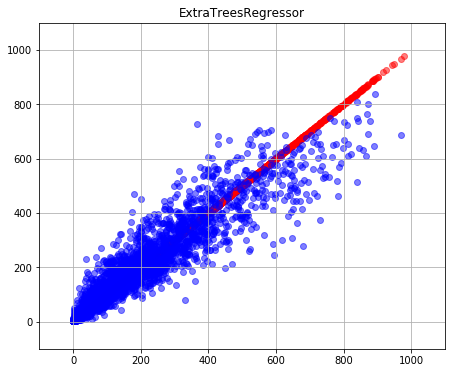

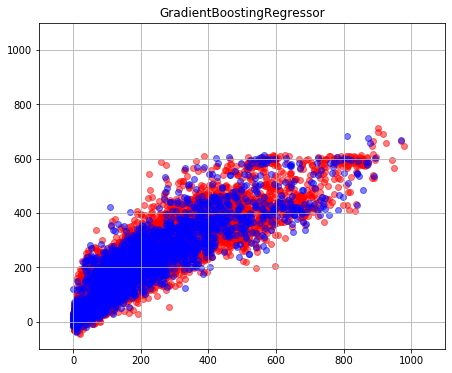

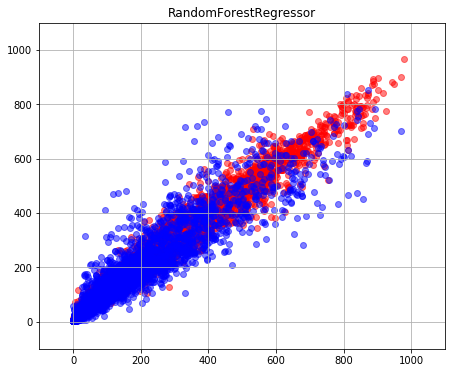

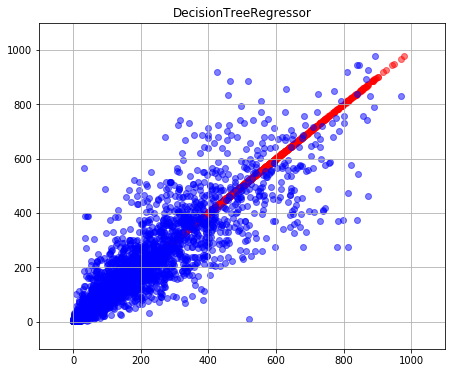

In [62]:
for name in estimators:
    pylab.figure(figsize = (16, 6))
    pylab.subplot(1, 2, 2)
    pylab.grid(True)
    pylab.xlim(-100, 1100)
    pylab.ylim(-100, 1100)
    pylab.scatter(train_labels, estimators[name].predict(np.array(train_data)), alpha = 0.5, color = 'red')
    pylab.scatter(test_labels, estimators[name].predict(np.array(test_data)), alpha = 0.5, color = 'blue')
    pylab.title(name)

По графикам можем заметить, что наиболее оптимальными моделями являются BaggingRegressor и RandomForestRegressor


Но согласно данным по оценке и средней ошибке выявляем, что самой хорошей моделью является Random Forest Regressor
score = 0,974
mean error = 44.03

In [34]:
# вывод предсказанных значений и настоящих 
print(test_labels[:10])
for name in estimators:
    print((estimators[name].predict(np.array(test_data)))[:10])

[  7   4   2   4 107   3 259 314 408 112]
[109.35205416 -91.3219667  -52.469441   -31.75192895 201.2263724
  48.54970105 391.88421928 268.11358595 290.68123269 313.81954875]
[109.15637246 -91.16815273 -52.37615613 -31.4037879  201.40688999
  48.28832346 391.8385809  267.98443371 291.01021393 313.67225802]
[108.87576948 -90.85441725 -52.11966961 -30.86428228 201.35171548
  48.23664055 391.45616943 267.17010624 291.36574696 313.57166361]
[120.4302258    8.35625841  28.24744372  56.58214378 195.85578992
  79.33176713 323.49974168 219.75301761 287.98668929 266.56466353]
[ 99.0937298  -82.46427175 -43.23726104  -7.21109229 198.70482874
  40.09523842 387.06374484 257.41084646 309.74365978 310.64300867]
[ 57.6744186   31.21492205  31.21492205  31.21492205 198.68939394
  31.21492205 346.33273743 327.03676471 390.34247967 390.34247967]
[  9.5   2.4   2.6   1.6  75.2   1.9 190.5 349.5 444.3 178.7]
[ 10.4   2.1   2.3  11.1  84.1   2.9 188.8 324.7 465.6 197.7]
[ 18.84107413   7.02365324  -1.309118

In [35]:
result = pd.read_csv('test.csv', header = 0, sep = ',')
result.datetime = result.datetime.apply(pd.to_datetime)
result['month'] = result.datetime.apply(lambda x : x.month)
result['hour'] = result.datetime.apply(lambda x : x.hour)
result['date'] = result.datetime.apply(lambda x : x.day)
result['weekday'] = result.datetime.apply(lambda x : x.weekday())
output = result
output = output.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour', 'date', 'weekday'], axis = 1)
result = result.drop(['datetime'], axis = 1)


predictions = estimators['RandomForestRegressor'].predict(np.array(result))
output = pd.read_csv('sampleSubmission.csv', header = 0, sep = ',')
output['count'] = predictions
output.to_csv('sampleSubmissionRandomForest.csv', index=False)
output.head()

,datetime,count
0,2011-01-20 00:00:00,10.1
1,2011-01-20 01:00:00,4.9
2,2011-01-20 02:00:00,3.6
3,2011-01-20 03:00:00,2.9
4,2011-01-20 04:00:00,3.1


### Результат на Kaggle - 0,46